In [2]:
import os
import keras
import random
import numpy as np
import tcc_util as util
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Dropout
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.models import Model
from keras.optimizers import Adam
from keras.models import model_from_json
from keras.applications import InceptionResNetV2
from keras.applications.inception_v3 import InceptionV3
from keras.applications import NASNetLarge
from keras.applications import ResNet50
from keras.applications import VGG16

import matplotlib.pyplot as plt
import itertools
from skimage import transform
from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.metrics import classification_report, confusion_matrix

import time

current_milli_time = lambda: int(round(time.time() * 1000))

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
def Inception_Model():
    conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(150,150,3))
    conv_base.traiable = False
    model = Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(16, activation='softmax'))
    
    return model

def InceptionResnet_Model():
    conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))
    conv_base.traiable = False
    
    for layer in conv_base.layers[:10]:
        layer.trainable = False
    
    x = conv_base.output
    x = Flatten()(x)
    x = Dense(4096, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation="relu")(x)
    x = Dropout(0.5)(x)
    predictions = Dense(16, activation="softmax")(x)
    
    model = Model(input = conv_base.input, output = predictions)

#     model = Sequential()
#     model.add(conv_base)
#     for layer in model.layers[:5]:
#         layer.trainable = False
#     model.add(Flatten())
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(16, activation='softmax'))
    
    return model

def NasNetLarge_Model():
    conv_base = NASNetLarge(weights='imagenet', include_top=False, input_shape=(150,150,3))
    conv_base.traiable = False
    model = Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(16, activation='softmax'))
    
    return model

def Resnet50_Model():
    conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(150,150,3))
    conv_base.traiable = False
    model = Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(16, activation='softmax'))
    
    return model
    
def VGG16_Model():
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
    conv_base.traiable = False
    model = Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(16, activation='softmax'))
    
    return model

def rvi_generator(batch_size=100, img_proc_func = util.preprocess_image):
    #
    # Define train, validation and test lists
    #

    train_labels = []
    train_input = []

    #
    # Load validation and training dataset file
    #

    folder = "/media/matheusmortatti/External/rvl-cdip"

    train_file = []
    labels_file = open(folder + "/labels/train.txt")
    for line in labels_file:
        sp = line.split()
        train_file.append(sp)
    labels_file.close()

    #
    # Start training in batches since my gpu can't handle all
    # training data at once.
    #

    train_size = util.file_len(folder + "/labels/train.txt")

    while True:
        random.shuffle(train_file)
        for line in train_file:
            sp = line
            pp_img = img_proc_func(imread(folder + "/images/" + sp[0]), IMAGE_PP_SIZE)

            train_input.append(pp_img)
            train_labels.append(int(sp[1]))

            if len(train_input) >= batch_size:

                #
                # Create training data
                #

                x_train = np.asarray(train_input)
                y_train = util.make_labels(train_labels)
                
                yield (x_train, y_train)

                #
                # Reset lists for next iteration
                #

                train_input = []
                train_labels = []
        if len(train_input) > 0:

                #
                # Create training data
                #

                x_train = np.asarray(train_input)
                y_train = util.make_labels(train_labels)
                
                yield (x_train, y_tran)

                #
                # Reset lists for next iteration
                #

                train_input = []
                train_labels = []

def train_model(model, tbCallback, img_proc_func = util.preprocess_image):
    #
    # Define train, validation and test lists
    #

    train_labels = []
    val_labels = []
    test_labels = []

    train_input = []
    val_input = []
    test_input = []

    #
    # Load validation and training dataset file
    #

    folder = "/media/matheusmortatti/External/rvl-cdip"

    val_file = []
    labels_file = open(folder + "/labels/val.txt")
    for line in labels_file:
        sp = line.split()
        val_file.append(sp)
    labels_file.close()

    train_file = []
    labels_file = open(folder + "/labels/train.txt")
    for line in labels_file:
        sp = line.split()
        train_file.append(sp)
    labels_file.close()

    #
    # Start training in batches since my gpu can't handle all
    # training data at once.
    #

    trained = 0
    train_size = util.file_len(folder + "/labels/train.txt")

    for i in range(EPOCHS):
        random.shuffle(train_file)
        for line in train_file:
            sp = line
            pp_img = img_proc_func(imread(folder + "/images/" + sp[0]), IMAGE_PP_SIZE)

            train_input.append(pp_img)
            train_labels.append(int(sp[1]))

            if len(train_input) >= TRAIN_STEP:

                trained += len(train_input)

                #
                # Choose a subset of the validation data
                #

#                 ss_val = util.choices(val_file, k=VAL_SIZE)

#                 for v in ss_val:
#                     val_input.append(img_proc_func(imread(folder + "/images/" + v[0]), IMAGE_PP_SIZE))
#                     val_labels.append(int(v[1]))

#                 x_val = np.asarray(val_input)
#                 y_val = util.make_labels(val_labels)

                #
                # Create training data
                #

                x_train = np.asarray(train_input)
                y_train = util.make_labels(train_labels)

                model.fit(x_train, y_train,
                          batch_size=BATCH_SIZE,
                          epochs=1,
                          verbose=1,
#                           validation_data=(x_val, y_val),
                          callbacks=[tbCallback])

                #
                # Reset lists for next iteration
                #

                train_input = []
                train_labels = []
                val_input = []
                val_labels = []

                print("trained: " + str(trained) + " / " + str(train_size))
                
        save_model(model)
                
def save_model(model):
    model_json = model.to_json()
    with open("/media/matheusmortatti/External/document-classifier/models/" + MODEL_NAME + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("/media/matheusmortatti/External/document-classifier/weights/" + MODEL_NAME + ".h5")

In [4]:
IMAGE_PP_SIZE = [150, 150]
EPOCHS = 100
BATCH_SIZE = 100
TRAIN_STEP = 1000
VAL_SIZE = 100

MODEL_NAME = "imgnet_VGG16_rvi"
MODEL_BUILD = VGG16_Model

RELOAD_MODEL = False

In [5]:
if RELOAD_MODEL:
    try:
        json_file = open("/media/matheusmortatti/External/document-classifier/models/" + MODEL_NAME +'.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)
        # load weights into new model
        model.load_weights("/media/matheusmortatti/External/document-classifier/weights/" + MODEL_NAME + ".h5")
    except:
        model = MODEL_BUILD()
else:
    model = MODEL_BUILD()
    
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              33558528  
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_3 (Dense)              (None, 16)                65552     
Total params: 65,120,080
Trainable params: 65,120,080
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
#
# Train the model with the defined values
#
if not os.path.isdir('/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME):
    os.mkdir('/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME)

unique_folder = str(current_milli_time())
os.mkdir('/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME + '/' + unique_folder)

tbCallback = keras.callbacks.TensorBoard(log_dir='/media/matheusmortatti/External/document-classifier/logs/' + MODEL_NAME + '/' + unique_folder, histogram_freq=0,  
          write_graph=True, write_images=True)

NUM_TRAIN_IMAGES = util.file_len("/media/matheusmortatti/External/rvl-cdip" + "/labels/train.txt")
model.fit_generator(rvi_generator(),
                    steps_per_epoch=NUM_TRAIN_IMAGES // 100,
                    verbose=1,
                    epochs=15)
# train_model(model, tbCallback)

Epoch 1/15


/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


3200/3200 [==============================] - 8803s 3s/step - loss: 0.0451 - acc: 0.9855
Epoch 2/15
3200/3200 [==============================] - 8807s 3s/step - loss: 0.0377 - acc: 0.9881
Epoch 3/15
3200/3200 [==============================] - 8879s 3s/step - loss: 0.0299 - acc: 0.9908
Epoch 4/15
3200/3200 [==============================] - 8926s 3s/step - loss: 0.0255 - acc: 0.9921
Epoch 5/15
3200/3200 [==============================] - 8890s 3s/step - loss: 0.0214 - acc: 0.9935
Epoch 6/15
3200/3200 [==============================] - 8874s 3s/step - loss: 0.0188 - acc: 0.9943
Epoch 7/15
3200/3200 [==============================] - 8963s 3s/step - loss: 0.0174 - acc: 0.9948
Epoch 8/15
3200/3200 [==============================] - 8946s 3s/step - loss: 0.0154 - acc: 0.9955
Epoch 9/15
3200/3200 [==============================] - 8888s 3s/step - loss: 0.0147 - acc: 0.9956
Epoch 10/15
3200/3200 [==============================] - 8894s 3s/step - loss: 0.0125 - acc: 0.9964
Epoch 11/15
3200/320

In [13]:

save_model(model)

/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [20]:
MODEL_NAME = "imgnet_inceptionv3_rvi"

json_file = open("/media/matheusmortatti/External/document-classifier/models/" + MODEL_NAME +'.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("/media/matheusmortatti/External/document-classifier/weights/" + MODEL_NAME + ".h5")

In [21]:
folder = "/media/matheusmortatti/External/rvl-cdip"
labels_file = open(folder + "/labels/val.txt")

x_val = []
y_val = []
y_pred_total = np.array([])

for line in labels_file:
    sp = line.split()
    x_val.append(util.preprocess_image(imread(folder + "/images/" + sp[0]), IMAGE_PP_SIZE))
    y_val.append(int(sp[1]))
    
    if len(x_val) >= 5000:
        
        #
        # Predict validation classes
        #
        
        x_val = np.asarray(x_val)
        y_pred = model.predict_classes(x_val)
        y_pred_total = np.append(y_pred_total, y_pred)
        print(y_pred_total.shape)
        x_val = []
        
if len(x_val) > 0:
        
    #
    # Predict validation classes
    #

    x_val = np.asarray(x_val)
    y_pred = model.predict_classes(x_val)
    y_pred_total = np.append(y_pred_total, y_pred)
    print(y_pred_total.shape)
    x_val = []
        

/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/matheusmortatti/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(5000,)
(10000,)
(15000,)
(20000,)
(25000,)
(30000,)
(35000,)
(40000,)


In [22]:
y_val = np.asarray(y_val)
print('Confusion Matrix')
print(confusion_matrix(y_val, y_pred_total))
print(classification_report(y_val, y_pred_total))

Confusion Matrix
[[2044   44   41   39   15   22    5   12   13    4    7   29   41   43
    11   60]
 [  69 1748   16   44   16   95    9   48   39    7   80  158   23  159
     9   17]
 [  27   12 2421    0    4    1    4    8    3    3   13    0   12   14
     3    5]
 [  18   31    1 2223   34    4    3    8   18    3   12   15   10   50
     0    4]
 [  11   19    3   19 2272    5   10    5   29   48    5    7   61   20
     3    5]
 [  23   95   16   29   14 1587   69   26   41   25  137   24  258   97
    36   31]
 [   4    8    6    1   45   42 2192    1   24  117    9    4   37   26
     9    1]
 [  16   72    8   20   11   36    4 2221    5    3   41   11   19   46
     4   14]
 [   1    6    0    7   23    5    4    0 2337    2    9    8   35   10
     2    2]
 [  16    9   22    1  135   11   96    5   15 2073    8    3   93   22
     7   10]
 [  17   53    4   13    8   60    2   39   38    3 2010   77   80   59
     5   17]
 [  54  118    2   17    9   35    1   17   19  

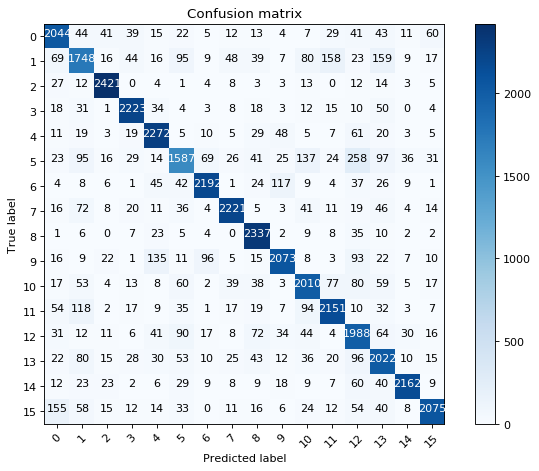

In [23]:
util.plot_confusion_matrix(confusion_matrix(y_val, y_pred_total), np.arange(16))